In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import RK45
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import sys

In [16]:
class calc:
    def __init__(self, lam, phi_i, V0 = 1e3, t_fin = 1e10):
        self.lam = lam
        self.phi_i = phi_i
        self.V0 = V0
        self.t_fin = t_fin
        self.dphi_i = -self.Vphi(self.phi_i) / np.sqrt(3.*self.V(self.phi_i))
        self.t = np.array([])
        self.solphi = np.array([])
        self.soldphi = np.array([])
        self.N = np.array([])
        self.H = np.array([])
        self.ep = np.array([])
        self.et = np.array([])

    def V(self, phi):
        return self.V0 * (1 - self.lam * phi**4)

    def Vphi(self,phi):
        return -4. * self.V0 * self.lam * phi**3

    def Vphiphi(self,phi):
        return -12. * self.V0 * self.lam * phi**2

    def epsilon(self,phi):
        return 0.5 * (self.Vphi(phi) / self.V(phi))**2

    def eta(self,phi):
        return self.Vphiphi(phi) / self.V(phi)

    def Hubble(self,phi,dphi):
        return np.sqrt(1./3. * (0.5 * dphi**2 + self.V(phi)))
    
    def solve(self):
        def func(t, y):
            phi, dphi, N, H = y
            dydt = [dphi, -3. * H * dphi - self.Vphi(phi), H, -1/2*dphi**2]
            return dydt 
        y0 = [self.phi_i,self.dphi_i, 0., self.Hubble(self.phi_i,self.dphi_i)]
        sol = RK45(func, 1e-9, y0, self.t_fin,rtol=5e-14,atol=1e-20)

        while(True):
            t_val = sol.t
            solphi_v, soldphi_v, N_v, H_v = sol.y[0], sol.y[1], sol.y[2], sol.y[3]
            self.t = np.append(self.t, t_val)
            self.solphi = np.append(self.solphi,solphi_v)
            self.soldphi = np.append(self.soldphi,soldphi_v)
            self.N = np.append(self.N,N_v)
            self.H = np.append(self.H,H_v)
            self.ep = np.append(self.ep, self.epsilon(solphi_v))
            self.et = np.append(self.et, self.eta(solphi_v))
            sys.stdout.write("\r lambda = %.2e N = %.4f ep = %.2e" % (self.lam, N_v,self.epsilon(solphi_v)))
            if (sol.status == 'finished') or (self.epsilon(solphi_v) > 1):
                break
            if ((H_v-self.Hubble(solphi_v,soldphi_v))/H_v>0.1):
                sys.stdout.write("\r Error")
                break
            sol.step()

        epN_ip = interp1d(self.ep, self.N, kind="cubic")
        Nep_ip = interp1d(self.N, self.ep, kind="cubic")
        Net_ip = interp1d(self.N, self.et, kind="cubic")
        self.ep_50 = float(Nep_ip(epN_ip(1.)-50))
        self.et_50 = float(Net_ip(epN_ip(1.)-50))
        self.ep_60 = float(Nep_ip(epN_ip(1.)-60))
        self.et_60 = float(Net_ip(epN_ip(1.)-60))
        
        self.ns_50 = 1. -6.*self.ep_50 + 2.* self.et_50
        self.r_50 = 16. * self.ep_50
        self.ns_60 = 1. -6.*self.ep_60 + 2.* self.et_60
        self.r_60 = 16. * self.ep_60

In [17]:
ns_50 = np.array([])
ns_60 = np.array([])
r_50 = np.array([])
r_60 = np.array([])

for i in np.logspace(-5, -1, 10, base=10):
    a = calc(lam=i,phi_i=1/i**0.25/20)
    a.solve()
    ns_50 = np.append(ns_50, a.ns_50)
    ns_60 = np.append(ns_60, a.ns_60)
    r_50 = np.append(r_50, a.r_50)
    r_60 = np.append(r_60, a.r_60)

 lambda = 1.00e-01 N = 159.6250 ep = 1.00e+0000

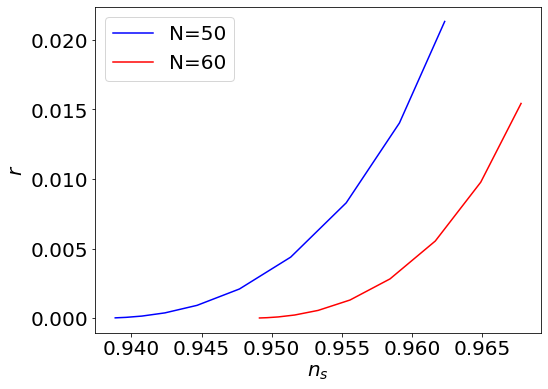

In [21]:
plt.rcParams["font.size"] = 20
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$n_s$")
ax.set_ylabel(r"$r$")

nsr50 = interp1d(ns_50, r_50, kind="cubic")
nsr60 = interp1d(ns_60, r_60, kind="cubic")
ns_50a = np.linspace(ns_50[0],ns_50[-1],1000)
ns_60a = np.linspace(ns_60[0],ns_60[-1],1000)
# ax.plot(ns_50, r_50, color = "blue", label="N=50")
# ax.plot(ns_60, r_60, color = "red", label="N=60")
ax.plot(ns_50a, nsr50(ns_50a), color = "blue", label="N=50")
ax.plot(ns_60a, nsr60(ns_60a), color = "red", label="N=60")
plt.legend()